PML parameters:
  α₀ = 1.79
  f₀ = 400000000.0
  L_pml = 0.4500 m
  ω = 2.51e+09 rad/s
  PML thickness = 12 grid points

Solving FDFD system...
Setting up incident field...
Building FDFD matrix...
Building source vector...
Solving linear system...


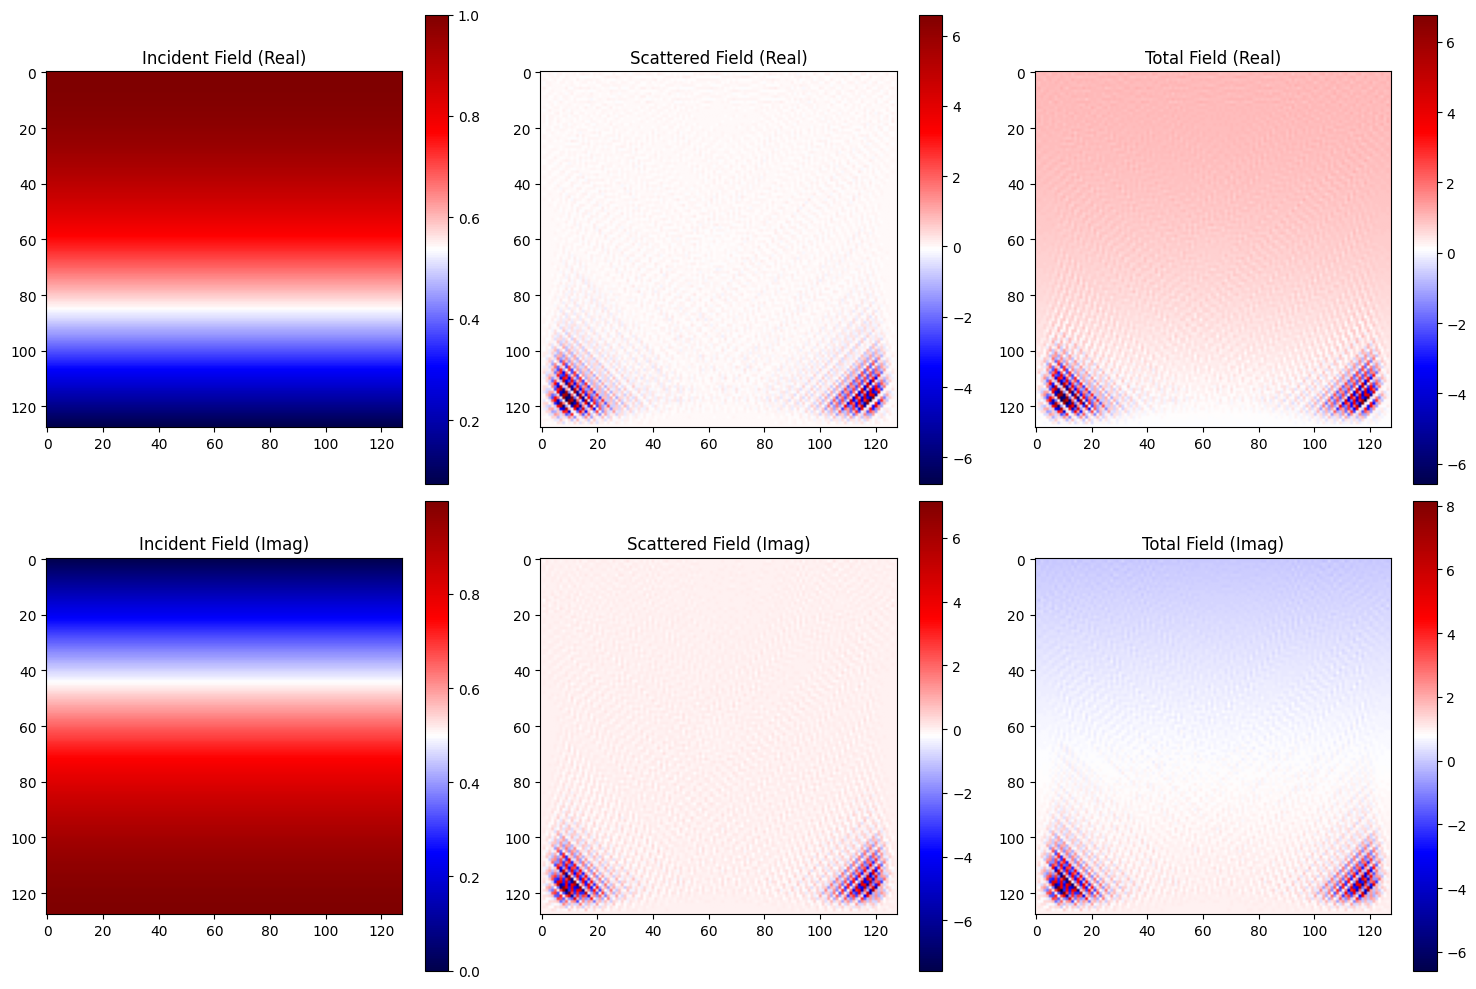

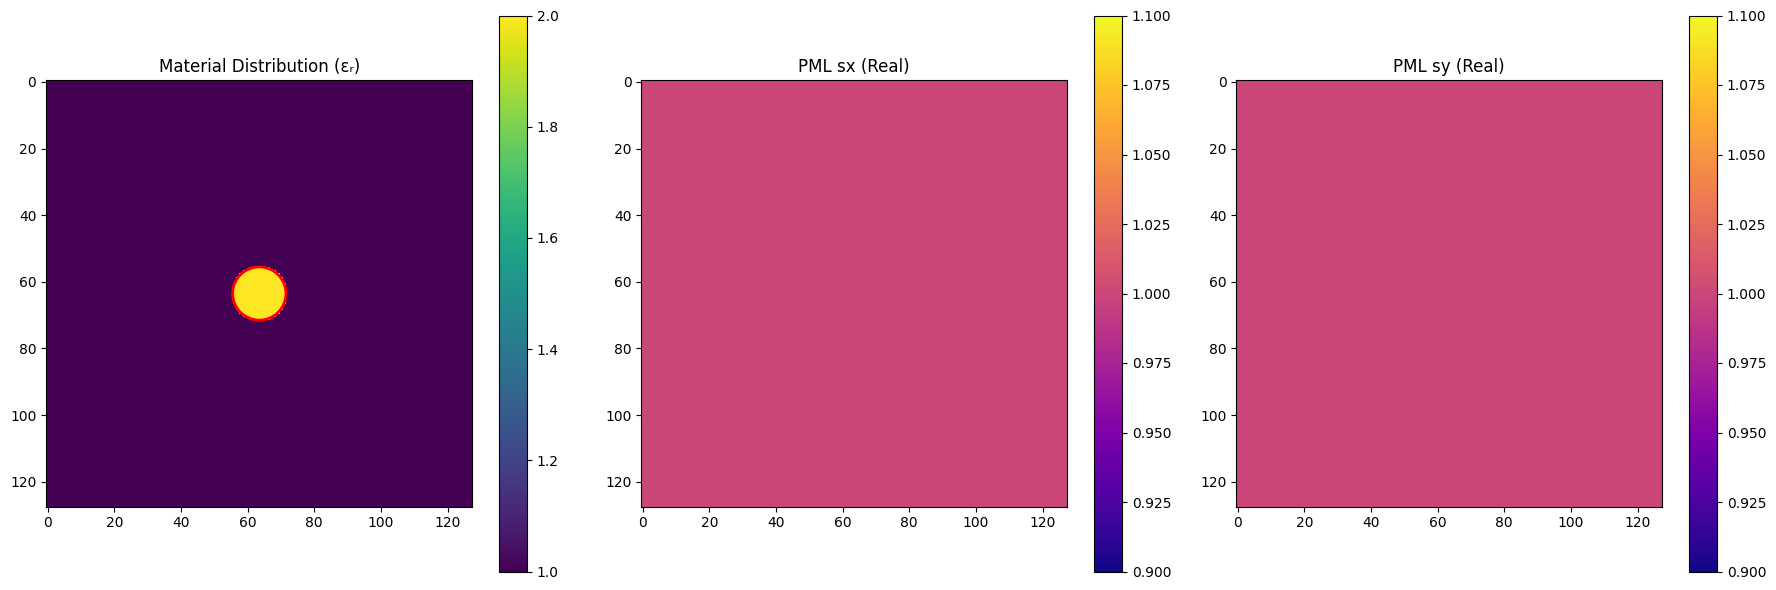

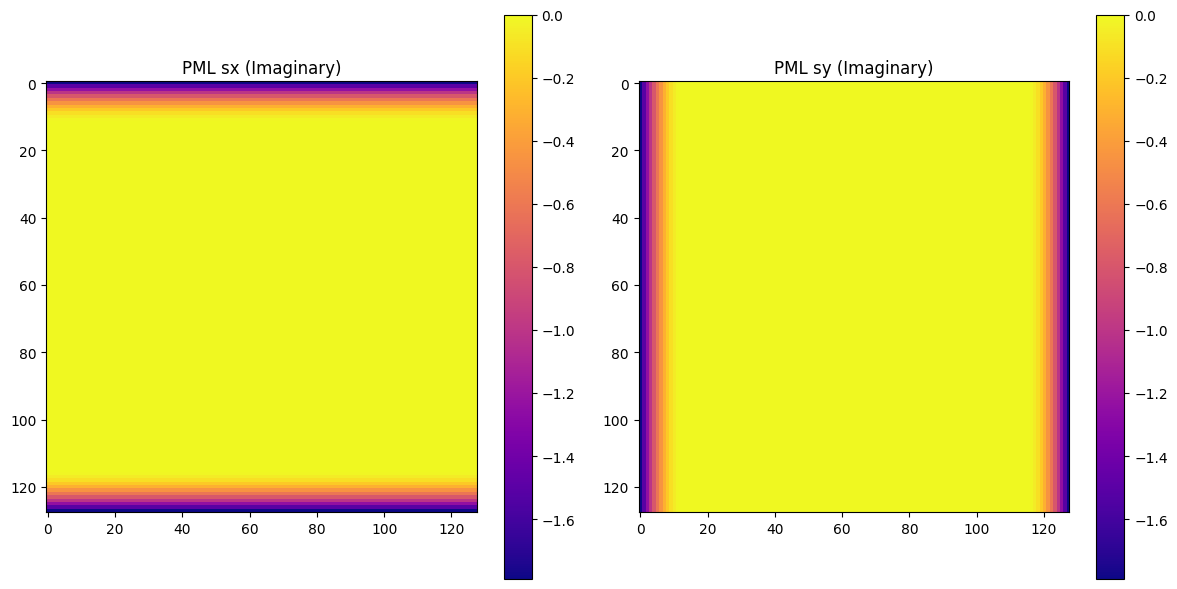


Grid size: 128x128
k0 = 8.378 rad/m
Wavelength = 0.750 m
Grid spacing: 0.0375
Solution completed!


In [11]:
import numpy as np

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

class FDFDSolver:
    def __init__(self):
        # Grid parameters
        self.L_total = 128  # Total grid size
        self.L_object = 64  # Object region size
        self.dx = 0.0375
        self.dy = 0.0375
        
        # Physical parameters
        self.freq = 400e6  # 400 MHz
        self.omega = 2 * np.pi * self.freq
        self.c = 3e8
        self.k0 = self.omega / self.c  # k0 = 8.378 rad/m
        
        # Material properties
        self.eps_r_object = 2.0 + 0j
        self.eps_r_free = 1.0 + 0j
        self.k_object = self.k0 * np.sqrt(self.eps_r_object)
        self.k_free = self.k0 * np.sqrt(self.eps_r_free)
        
        # PML parameters
        self.pml_thickness = 12
        self.alpha0 = 1.79
        self.f0 = 400e6
        self.L_pml = self.pml_thickness * self.dx  # PML thickness in physical units
        
        # Grid setup
        self.setup_grid()
        
    def setup_grid(self):
        """Setup the computational grid and material properties"""
        # Create coordinate arrays
        self.x = np.arange(self.L_total) * self.dx
        self.y = np.arange(self.L_total) * self.dy
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')
        
        # Grid centers
        self.x_center = (self.L_total - 1) / 2
        self.y_center = (self.L_total - 1) / 2
        
        # Physical coordinates of center
        self.x0_phys = self.x_center * self.dx
        self.y0_phys = self.y_center * self.dy
        
        # Create material map
        self.eps_r = np.ones((self.L_total, self.L_total), dtype=complex)
        
        # Object region (circular)
        self.create_circular_object()
        
        # PML regions
        self.create_pml_regions()
        
    def create_circular_object(self):
        """Create circular object at center"""
        # Object boundaries in grid coordinates
        obj_start = (self.L_total - self.L_object) // 2
        obj_end = obj_start + self.L_object
        
        # Circular object radius (from your function)
        radius = 8  # grid points
        
        i_indices = np.arange(self.L_total)
        j_indices = np.arange(self.L_total)
        ii, jj = np.meshgrid(i_indices, j_indices, indexing='ij')
        
        # Create circular mask
        mask = (ii - self.x_center)**2 + (jj - self.y_center)**2 <= radius**2
        self.eps_r[mask] = self.eps_r_object
        
        # Store object mask for later use
        self.object_mask = mask
        
    def create_pml_regions(self):
        """Create PML regions with complex coordinate stretching based on your equation"""
        self.sx = np.ones(self.L_total, dtype=complex)
        self.sy = np.ones(self.L_total, dtype=complex)
        
        # Calculate stretching functions s_x and s_y
        for i in range(self.L_total):
            x_phys = i * self.dx
            
            # Left PML
            if i < self.pml_thickness:
                dist_from_boundary = (self.pml_thickness - i) * self.dx
                # s_x = 1 - 2iπα₀f₀(x-x₀)²/L²pmlω
                self.sx[i] = 1 - 2j * np.pi * self.alpha0 * self.f0 * (dist_from_boundary)**2 / (self.L_pml**2 * self.omega)
                
            # Right PML  
            elif i >= self.L_total - self.pml_thickness:
                dist_from_boundary = (i - (self.L_total - self.pml_thickness - 1)) * self.dx
                self.sx[i] = 1 - 2j * np.pi * self.alpha0 * self.f0 * (dist_from_boundary)**2 / (self.L_pml**2 * self.omega)
                
        for j in range(self.L_total):
            y_phys = j * self.dy
            
            # Bottom PML
            if j < self.pml_thickness:
                dist_from_boundary = (self.pml_thickness - j) * self.dy
                self.sy[j] = 1 - 2j * np.pi * self.alpha0 * self.f0 * (dist_from_boundary)**2 / (self.L_pml**2 * self.omega)
                
            # Top PML
            elif j >= self.L_total - self.pml_thickness:
                dist_from_boundary = (j - (self.L_total - self.pml_thickness - 1)) * self.dy
                self.sy[j] = 1 - 2j * np.pi * self.alpha0 * self.f0 * (dist_from_boundary)**2 / (self.L_pml**2 * self.omega)
    
    def get_pml_derivatives(self, i, j):
        """Calculate the PML derivative terms from your equation"""
        # Initialize derivative terms
        dsx_dx = 0.0
        dsy_dy = 0.0
        
        # X-direction PML derivative
        if i < self.pml_thickness:
            dist_from_boundary = (self.pml_thickness - i) * self.dx
            # d/dx[s_x] = d/dx[1 - 2iπα₀f₀(x-x₀)²/L²pmlω]
            dsx_dx = -2j * np.pi * self.alpha0 * self.f0 * 2 * (-dist_from_boundary) * (-self.dx) / (self.L_pml**2 * self.omega)
            
        elif i >= self.L_total - self.pml_thickness:
            dist_from_boundary = (i - (self.L_total - self.pml_thickness - 1)) * self.dx
            dsx_dx = -2j * np.pi * self.alpha0 * self.f0 * 2 * (dist_from_boundary) * (self.dx) / (self.L_pml**2 * self.omega)
            
        # Y-direction PML derivative
        if j < self.pml_thickness:
            dist_from_boundary = (self.pml_thickness - j) * self.dy
            dsy_dy = -2j * np.pi * self.alpha0 * self.f0 * 2 * (-dist_from_boundary) * (-self.dy) / (self.L_pml**2 * self.omega)
            
        elif j >= self.L_total - self.pml_thickness:
            dist_from_boundary = (j - (self.L_total - self.pml_thickness - 1)) * self.dy
            dsy_dy = -2j * np.pi * self.alpha0 * self.f0 * 2 * (dist_from_boundary) * (self.dy) / (self.L_pml**2 * self.omega)
            
        return dsx_dx, dsy_dy
    
    def incident_field(self, x0=0, y0=0, theta=0):
        """Calculate incident field Ei(x,y,x0,y0,θ,k)"""
        # Convert to physical coordinates
        x_phys = self.X * self.dx
        y_phys = self.Y * self.dy
        
        # Incident field: plane wave
        phase = self.k_free * ((x_phys - x0) * np.cos(theta) + (y_phys - y0) * np.sin(theta))
        Ei = np.exp(1j * phase)
        
        return Ei
    
    def build_fdfd_matrix(self):
        """Build the FDFD system matrix A for Ax = b with corrected PML"""
        N = self.L_total * self.L_total
        
        # Create sparse matrix
        row_indices = []
        col_indices = []
        data = []
        
        for i in range(self.L_total):
            for j in range(self.L_total):
                idx = i * self.L_total + j
                
                # Get material properties at this point
                eps_r = self.eps_r[i, j]
                k = self.k0 * np.sqrt(eps_r)
                
                # PML stretching factors
                sx_i = self.sx[i]
                sy_j = self.sy[j]
                
                # Get PML derivative terms
                dsx_dx, dsy_dy = self.get_pml_derivatives(i, j)
                
                # Central point coefficient (k₀² term)
                coeff_center = k**2
                
                row_indices.append(idx)
                col_indices.append(idx)
                data.append(coeff_center)
                
                # Second derivatives with PML stretching
                # ∂²Es/∂x² term with 1/sx stretching
                if i > 0 and i < self.L_total - 1:
                    # Central difference for second derivative
                    coeff_center += -2.0 / (self.dx**2 * sx_i)
                    
                    # Left neighbor
                    coeff_left = 1.0 / (self.dx**2 * sx_i)
                    row_indices.append(idx)
                    col_indices.append((i-1) * self.L_total + j)
                    data.append(coeff_left)
                    
                    # Right neighbor
                    coeff_right = 1.0 / (self.dx**2 * sx_i)
                    row_indices.append(idx)
                    col_indices.append((i+1) * self.L_total + j)
                    data.append(coeff_right)
                
                # ∂²Es/∂y² term with 1/sy stretching
                if j > 0 and j < self.L_total - 1:
                    # Central difference for second derivative
                    coeff_center += -2.0 / (self.dy**2 * sy_j)
                    
                    # Bottom neighbor
                    coeff_bottom = 1.0 / (self.dy**2 * sy_j)
                    row_indices.append(idx)
                    col_indices.append(i * self.L_total + (j-1))
                    data.append(coeff_bottom)
                    
                    # Top neighbor
                    coeff_top = 1.0 / (self.dy**2 * sy_j)
                    row_indices.append(idx)
                    col_indices.append(i * self.L_total + (j+1))
                    data.append(coeff_top)
                
                # First derivative terms with PML corrections
                # ∂Es/∂x term with coefficient dsx_dx/sx²
                if i > 0 and i < self.L_total - 1 and abs(dsx_dx) > 1e-12:
                    coeff_dx = dsx_dx / (sx_i**2)
                    
                    # Central difference for first derivative
                    # Left neighbor contribution
                    row_indices.append(idx)
                    col_indices.append((i-1) * self.L_total + j)
                    data.append(-coeff_dx / (2 * self.dx))
                    
                    # Right neighbor contribution
                    row_indices.append(idx)
                    col_indices.append((i+1) * self.L_total + j)
                    data.append(coeff_dx / (2 * self.dx))
                
                # ∂Es/∂y term with coefficient dsy_dy/sy²
                if j > 0 and j < self.L_total - 1 and abs(dsy_dy) > 1e-12:
                    coeff_dy = dsy_dy / (sy_j**2)
                    
                    # Central difference for first derivative
                    # Bottom neighbor contribution
                    row_indices.append(idx)
                    col_indices.append(i * self.L_total + (j-1))
                    data.append(-coeff_dy / (2 * self.dy))
                    
                    # Top neighbor contribution
                    row_indices.append(idx)
                    col_indices.append(i * self.L_total + (j+1))
                    data.append(coeff_dy / (2 * self.dy))
                
                # Update center coefficient
                data[idx] = coeff_center
        
        # Create sparse matrix
        A = sp.csr_matrix((data, (row_indices, col_indices)), shape=(N, N))
        
        return A
    
    def build_source_vector(self, Ei):
        """Build source vector b for Ax = b"""
        N = self.L_total * self.L_total
        b = np.zeros(N, dtype=complex)
        
        for i in range(self.L_total):
            for j in range(self.L_total):
                idx = i * self.L_total + j
                
                # Source term only in object region
                if self.object_mask[i, j]:
                    # Source: -(k^2 - k0^2) * Ei
                    k_obj_sq = self.k_object**2
                    k0_sq = self.k_free**2
                    source_term = -(k_obj_sq - k0_sq) * Ei[i, j]
                    b[idx] = source_term
        
        return b
    # def build_source_vector(self, Ei):
    #     """Build source vector b for Ax = b"""
    #     N = self.L_total * self.L_total
    #     b = np.zeros(N, dtype=complex)
        
    #     # Calculate second derivatives of incident field
    #     d2Ei_dx2 = np.zeros_like(Ei)
    #     d2Ei_dy2 = np.zeros_like(Ei)
        
    #     # Central difference for second derivatives
    #     for i in range(1, self.L_total-1):
    #         for j in range(1, self.L_total-1):
    #             d2Ei_dx2[i,j] = (Ei[i+1,j] - 2*Ei[i,j] + Ei[i-1,j]) / (self.dx**2)
    #             d2Ei_dy2[i,j] = (Ei[i,j+1] - 2*Ei[i,j] + Ei[i,j-1]) / (self.dy**2)
        
    #     for i in range(self.L_total):
    #         for j in range(self.L_total):
    #             idx = i * self.L_total + j
                
    #             # Source term only in object region
    #             if self.object_mask[i, j]:
    #                 # Object region equation: RHS = -[∂²Ei/∂x² + ∂²Ei/∂y² + k²Ei]
    #                 k_obj_sq = self.k_object**2
    #                 source_term = -(d2Ei_dx2[i,j] + d2Ei_dy2[i,j] + k_obj_sq * Ei[i,j])
    #                 b[idx] = source_term
        
    #     return b
    
    def solve_fdfd(self, theta=0):
        """Solve the FDFD system"""
        print("Setting up incident field...")
        Ei = self.incident_field(theta=theta)
        
        print("Building FDFD matrix...")
        A = self.build_fdfd_matrix()
        
        print("Building source vector...")
        b = self.build_source_vector(Ei)
        
        print("Solving linear system...")
        Es_vec = spsolve(A, b)
        
        # Reshape to 2D grid
        Es = Es_vec.reshape(self.L_total, self.L_total)
        
        # Total field
        Et = Ei + Es
        
        return Es, Et, Ei
    
    def plot_results(self, Es, Et, Ei):
        """Plot the results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Real parts
        im1 = axes[0,0].imshow(np.real(Ei), cmap='seismic', aspect='equal')
        axes[0,0].set_title('Incident Field (Real)')
        plt.colorbar(im1, ax=axes[0,0])
        
        im2 = axes[0,1].imshow(np.real(Es), cmap='seismic', aspect='equal')
        axes[0,1].set_title('Scattered Field (Real)')
        plt.colorbar(im2, ax=axes[0,1])
        
        im3 = axes[0,2].imshow(np.real(Et), cmap='seismic', aspect='equal')
        axes[0,2].set_title('Total Field (Real)')
        plt.colorbar(im3, ax=axes[0,2])
        
        # Imaginary parts
        im4 = axes[1,0].imshow(np.imag(Ei), cmap='seismic', aspect='equal')
        axes[1,0].set_title('Incident Field (Imag)')
        plt.colorbar(im4, ax=axes[1,0])
        
        im5 = axes[1,1].imshow(np.imag(Es), cmap='seismic', aspect='equal')
        axes[1,1].set_title('Scattered Field (Imag)')
        plt.colorbar(im5, ax=axes[1,1])
        
        im6 = axes[1,2].imshow(np.imag(Et), cmap='seismic', aspect='equal')
        axes[1,2].set_title('Total Field (Imag)')
        plt.colorbar(im6, ax=axes[1,2])
        
        plt.tight_layout()
        plt.show()
        
        # Plot material distribution and PML regions
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Material distribution
        im1 = axes[0].imshow(np.real(self.eps_r), cmap='viridis', aspect='equal')
        axes[0].set_title('Material Distribution (εᵣ)')
        plt.colorbar(im1, ax=axes[0])
        
        # Add circle outline
        circle = plt.Circle((self.y_center, self.x_center), 8, fill=False, color='red', linewidth=2)
        axes[0].add_patch(circle)
        
        # PML stretching factors
        sx_2d = np.tile(self.sx.reshape(-1, 1), (1, self.L_total))
        sy_2d = np.tile(self.sy.reshape(1, -1), (self.L_total, 1))
        
        im2 = axes[1].imshow(np.real(sx_2d), cmap='plasma', aspect='equal')
        axes[1].set_title('PML sx (Real)')
        plt.colorbar(im2, ax=axes[1])
        
        im3 = axes[2].imshow(np.real(sy_2d), cmap='plasma', aspect='equal')
        axes[2].set_title('PML sy (Real)')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
        
        # Plot PML imaginary parts
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        im1 = axes[0].imshow(np.imag(sx_2d), cmap='plasma', aspect='equal')
        axes[0].set_title('PML sx (Imaginary)')
        plt.colorbar(im1, ax=axes[0])
        
        im2 = axes[1].imshow(np.imag(sy_2d), cmap='plasma', aspect='equal')
        axes[1].set_title('PML sy (Imaginary)')
        plt.colorbar(im2, ax=axes[1])
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create solver
    solver = FDFDSolver()
    
    # Print PML parameters
    print(f"PML parameters:")
    print(f"  α₀ = {solver.alpha0}")
    print(f"  f₀ = {solver.f0}")
    print(f"  L_pml = {solver.L_pml:.4f} m")
    print(f"  ω = {solver.omega:.2e} rad/s")
    print(f"  PML thickness = {solver.pml_thickness} grid points")
    
    # Solve for normal incidence (θ = 0)
    print("\nSolving FDFD system...")
    Es, Et, Ei = solver.solve_fdfd(theta=0)
    
    # Plot results
    solver.plot_results(Es, Et, Ei)
    
    print(f"\nGrid size: {solver.L_total}x{solver.L_total}")
    print(f"k0 = {solver.k0:.3f} rad/m")
    print(f"Wavelength = {2*np.pi/solver.k0:.3f} m")
    print(f"Grid spacing: {solver.dx}")
    print("Solution completed!")

Solving FDFD system...
Setting up incident field...
Building FDFD matrix...
Building source vector...
Solving linear system...


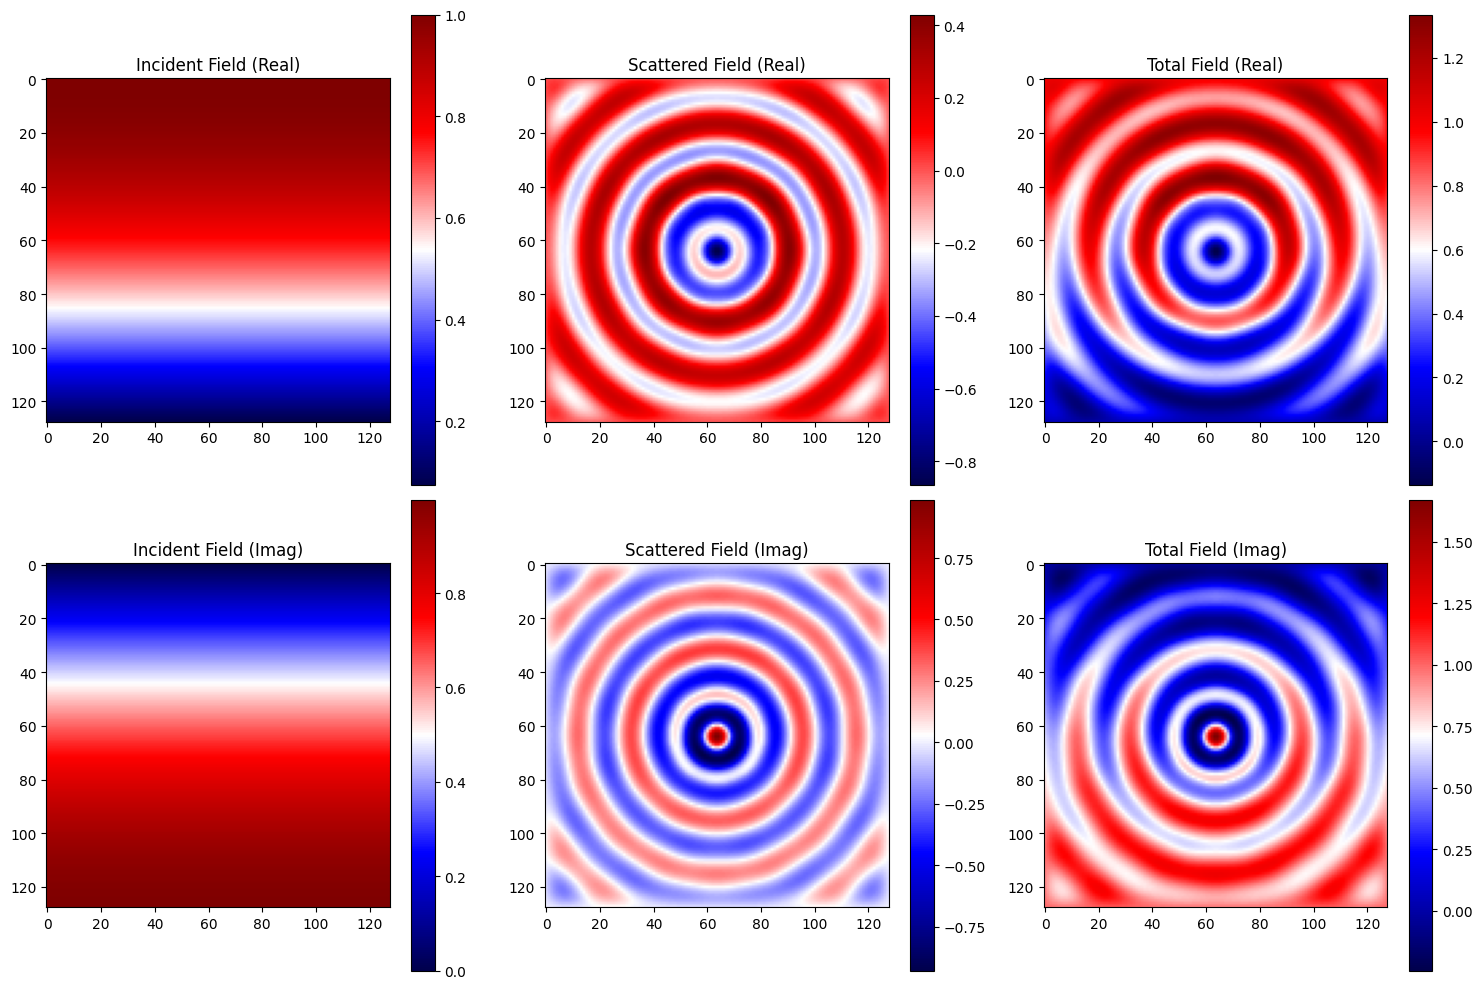

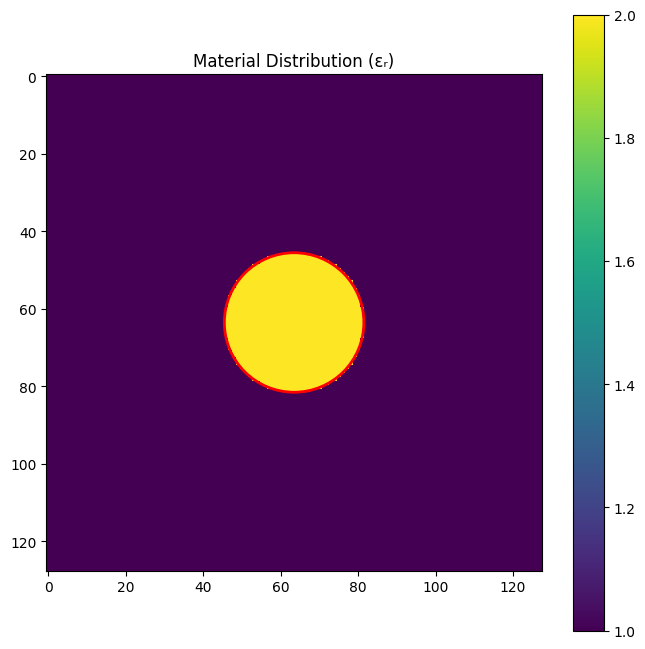

Grid size: 128x128
k0 = 8.378 rad/m
Wavelength = 0.750 m
Grid spacing: 0.0375
Solution completed!


In [17]:
import numpy as np

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

class FDFDSolver:
    def __init__(self):
        # Grid parameters
        self.L_total = 128  # Total grid size
        self.L_object = 64  # Object region size
        self.dx = 0.0375
        self.dy = 0.0375
        
        # Physical parameters
        self.freq = 400e6  # 400 MHz
        self.omega = 2 * np.pi * self.freq
        self.c = 3e8
        self.k0 = self.omega / self.c  # k0 = 8.378 rad/m
        
        # Material properties
        self.eps_r_object = 2.0 + 0j
        self.eps_r_free = 1.0 + 0j
        self.k_object = self.k0 * np.sqrt(self.eps_r_object)
        self.k_free = self.k0 * np.sqrt(self.eps_r_free)
        
        # PML parameters
        self.pml_thickness = 12
        self.alpha0 = 1.79
        self.f0 = 4e8
        
        # Grid setup
        self.setup_grid()
        
    def setup_grid(self):
        """Setup the computational grid and material properties"""
        # Create coordinate arrays
        self.x = np.arange(self.L_total) * self.dx
        self.y = np.arange(self.L_total) * self.dy
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')
        
        # Grid centers
        self.x_center = (self.L_total - 1) / 2
        self.y_center = (self.L_total - 1) / 2
        
        # Create material map
        self.eps_r = np.ones((self.L_total, self.L_total), dtype=complex)
        
        # Object region (circular)
        self.create_circular_object()
        
        # PML regions
        self.create_pml_regions()
        
    def create_circular_object(self):
        """Create circular object at center"""
        # Object boundaries in grid coordinates
        obj_start = (self.L_total - self.L_object) // 2
        obj_end = obj_start + self.L_object
        
        # Circular object radius (from your function)
        radius = 18  # grid points
        
        i_indices = np.arange(self.L_total)
        j_indices = np.arange(self.L_total)
        ii, jj = np.meshgrid(i_indices, j_indices, indexing='ij')
        
        # Create circular mask
        mask = (ii - self.x_center)**2 + (jj - self.y_center)**2 <= radius**2
        self.eps_r[mask] = self.eps_r_object
        
        # Store object mask for later use
        self.object_mask = mask
        
    def create_pml_regions(self):
        """Create PML regions with complex coordinate stretching"""
        self.sx = np.ones(self.L_total, dtype=complex)
        self.sy = np.ones(self.L_total, dtype=complex)
        
        # PML regions: outer 12 grid points
        for i in range(self.L_total):
            # Left PML
            if i < self.pml_thickness:
                dist = self.pml_thickness - i
                self.sx[i] = 1 + 1j * self.alpha0 * (dist / self.pml_thickness)**2
            # Right PML  
            elif i >= self.L_total - self.pml_thickness:
                dist = i - (self.L_total - self.pml_thickness - 1)
                self.sx[i] = 1 + 1j * self.alpha0 * (dist / self.pml_thickness)**2
                
        for j in range(self.L_total):
            # Bottom PML
            if j < self.pml_thickness:
                dist = self.pml_thickness - j
                self.sy[j] = 1 + 1j * self.alpha0 * (dist / self.pml_thickness)**2
            # Top PML
            elif j >= self.L_total - self.pml_thickness:
                dist = j - (self.L_total - self.pml_thickness - 1)
                self.sy[j] = 1 + 1j * self.alpha0 * (dist / self.pml_thickness)**2
    
    def incident_field(self, x0=0, y0=0, theta=0):
        """Calculate incident field Ei(x,y,x0,y0,θ,k)"""
        # Convert to physical coordinates
        x_phys = self.X * self.dx
        y_phys = self.Y * self.dy
        
        # Incident field: plane wave
        phase = self.k_free * ((x_phys - x0) * np.cos(theta) + (y_phys - y0) * np.sin(theta))
        Ei = np.exp(1j * phase)
        
        return Ei
    
    def build_fdfd_matrix(self):
        """Build the FDFD system matrix A for Ax = b"""
        N = self.L_total * self.L_total
        
        # Create sparse matrix
        row_indices = []
        col_indices = []
        data = []
        
        for i in range(self.L_total):
            for j in range(self.L_total):
                idx = i * self.L_total + j
                
                # Get material properties at this point
                eps_r = self.eps_r[i, j]
                k = self.k0 * np.sqrt(eps_r)
                
                # PML stretching factors
                sx_i = self.sx[i]
                sy_j = self.sy[j]
                
                # Central point coefficient
                coeff_center = (k**2 - 
                               (2.0 / (self.dx**2)) * (1.0 / sx_i) - 
                               (2.0 / (self.dy**2)) * (1.0 / sy_j))
                
                row_indices.append(idx)
                col_indices.append(idx)
                data.append(coeff_center)
                
                # X-direction derivatives
                if i > 0:  # Left neighbor
                    coeff_left = 1.0 / (self.dx**2 * sx_i)
                    row_indices.append(idx)
                    col_indices.append((i-1) * self.L_total + j)
                    data.append(coeff_left)
                
                if i < self.L_total - 1:  # Right neighbor
                    coeff_right = 1.0 / (self.dx**2 * sx_i)
                    row_indices.append(idx)
                    col_indices.append((i+1) * self.L_total + j)
                    data.append(coeff_right)
                
                # Y-direction derivatives
                if j > 0:  # Bottom neighbor
                    coeff_bottom = 1.0 / (self.dy**2 * sy_j)
                    row_indices.append(idx)
                    col_indices.append(i * self.L_total + (j-1))
                    data.append(coeff_bottom)
                
                if j < self.L_total - 1:  # Top neighbor
                    coeff_top = 1.0 / (self.dy**2 * sy_j)
                    row_indices.append(idx)
                    col_indices.append(i * self.L_total + (j+1))
                    data.append(coeff_top)
        
        # Create sparse matrix
        A = sp.csr_matrix((data, (row_indices, col_indices)), shape=(N, N))
        
        return A
    
    def build_source_vector(self, Ei):
        """Build source vector b for Ax = b"""
        N = self.L_total * self.L_total
        b = np.zeros(N, dtype=complex)
        
        for i in range(self.L_total):
            for j in range(self.L_total):
                idx = i * self.L_total + j
                
                # Source term only in object region
                if self.object_mask[i, j]:
                    # Source: -(k^2 - k0^2) * Ei
                    k_obj_sq = self.k_object**2
                    k0_sq = self.k_free**2
                    source_term = -(k_obj_sq - k0_sq) * Ei[i, j]
                    b[idx] = source_term
        
        return b
    
    def solve_fdfd(self, theta=0):
        """Solve the FDFD system"""
        print("Setting up incident field...")
        Ei = self.incident_field(theta=theta)
        
        print("Building FDFD matrix...")
        A = self.build_fdfd_matrix()
        
        print("Building source vector...")
        b = self.build_source_vector(Ei)
        
        print("Solving linear system...")
        Es_vec = spsolve(A, b)
        
        # Reshape to 2D grid
        Es = Es_vec.reshape(self.L_total, self.L_total)
        
        # Total field
        Et = Ei + Es
        
        return Es, Et, Ei
    
    def plot_results(self, Es, Et, Ei):
        """Plot the results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Real parts
        im1 = axes[0,0].imshow(np.real(Ei), cmap='seismic', aspect='equal')
        axes[0,0].set_title('Incident Field (Real)')
        plt.colorbar(im1, ax=axes[0,0])
        
        im2 = axes[0,1].imshow(np.real(Es), cmap='seismic', aspect='equal')
        axes[0,1].set_title('Scattered Field (Real)')
        plt.colorbar(im2, ax=axes[0,1])
        
        im3 = axes[0,2].imshow(np.real(Et), cmap='seismic', aspect='equal')
        axes[0,2].set_title('Total Field (Real)')
        plt.colorbar(im3, ax=axes[0,2])
        
        # Imaginary parts
        im4 = axes[1,0].imshow(np.imag(Ei), cmap='seismic', aspect='equal')
        axes[1,0].set_title('Incident Field (Imag)')
        plt.colorbar(im4, ax=axes[1,0])
        
        im5 = axes[1,1].imshow(np.imag(Es), cmap='seismic', aspect='equal')
        axes[1,1].set_title('Scattered Field (Imag)')
        plt.colorbar(im5, ax=axes[1,1])
        
        im6 = axes[1,2].imshow(np.imag(Et), cmap='seismic', aspect='equal')
        axes[1,2].set_title('Total Field (Imag)')
        plt.colorbar(im6, ax=axes[1,2])
        
        plt.tight_layout()
        plt.show()
        
        # Plot material distribution
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        im = ax.imshow(np.real(self.eps_r), cmap='viridis', aspect='equal')
        ax.set_title('Material Distribution (εᵣ)')
        plt.colorbar(im, ax=ax)
        
        # Add circle outline
        circle = plt.Circle((self.y_center, self.x_center), 18, fill=False, color='red', linewidth=2)
        ax.add_patch(circle)
        
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create solver
    solver = FDFDSolver()
    
    # Solve for normal incidence (θ = 0)
    print("Solving FDFD system...")
    Es, Et, Ei = solver.solve_fdfd(theta=0)
    
    # Plot results
    solver.plot_results(Es, Et, Ei)
    
    print(f"Grid size: {solver.L_total}x{solver.L_total}")
    print(f"k0 = {solver.k0:.3f} rad/m")
    print(f"Wavelength = {2*np.pi/solver.k0:.3f} m")
    print(f"Grid spacing: {solver.dx}")
    print("Solution completed!")